In [1]:
import os
import ee
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

import geemap

from geeml.utils import eeprint

In [2]:
import ee
service_account = 'github-action@ee-geethensingh.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, r"C:\Users\coach\myfiles\postdoc\Fire\code\secret.json")
ee.Initialize(credentials)

In [3]:
os.chdir(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components")
os.getcwd()

'C:\\Users\\coach\\myfiles\\postdoc\\Fire\\code\\Burn_Area_Mapping\\src\\components'

In [4]:
from data_extraction import extractDataset
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:

Map = geemap.Map()
fc = ee.FeatureCollection("projects/ee-geethensingh/assets/postdoc/proj_fired_south_africa_to2021182_events")
Map.addLayer(ee.Feature(fc.first()), {'color': 'red'}, "Fire Test")
Map.centerObject(fc.first(), 12)
Map

Map(center=[-31.374999751707104, 29.510986261502627], controls=(WidgetControl(options=['position', 'transparen…

## Step 1: Data extraction

In [7]:
# Filter fire events to period and area of interest
fireEvents = fc.map(lambda ft: ft.set('system:time_start', ee.Date(ft.get('ig_date')))
                    .set('system:time_end', ee.Date(ft.get('last_date')))).filterDate('2019-01-01', '2020-01-01')

In [8]:
# Get Landsat-8 features for South Africa
extractDataset('LANDSAT_8', 'South Africa', ee.Date('2019-09-01'), ee.Date('2020-01-01'), fireEvents, 16, 'extract_20190912.csv')

  0%|          | 0/572 [00:00<?, ?it/s]

## Step 2: train and eval

In [7]:
from data_ingestion import dataIngestion
from data_transformation import dataTransformation
from model_trainer import modelTrainer

Naive Baseline Accuracy: 0.74
No best model found, metric < 0.6


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached 'artifacts'
            git commit -m "stop tracking artifacts" 


classification report               precision    recall  f1-score   support

         0.0       0.79      0.93      0.86       206
         1.0       0.59      0.28      0.38        71

    accuracy                           0.77       277
   macro avg       0.69      0.61      0.62       277
weighted avg       0.74      0.77      0.73       277

Confusion Matrix:


0.380952380952381

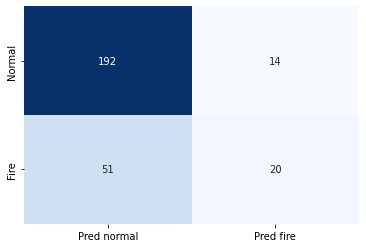

In [8]:
obj = dataIngestion()
train_path, calibration_path, test_path = obj.initiate_data_ingestion()
data_transformation = dataTransformation()
train_arr, cal_arr, test_arr = data_transformation.initiate_data_transformation(train_path, calibration_path, test_path)

model_trainer = modelTrainer()
model_trainer.initiate_model_trainer(train_arr, cal_arr, test_arr)

## Step 3: Inference

In [21]:
from src.utils import load_object
import pandas as pd

from mapie.classification import MapieClassifier

# model = load_object(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\model.pkl")
df = pd.read_csv(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\train.csv")


X_train = df.drop(['scenes', 'label'], axis=1)
y_train = df[['label']]

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state= 42, verbose= False).fit(X_train, y_train)
print(model.predict(dfPredict))

mapie_score = MapieClassifier(estimator = model, cv="prefit", method="lac", random_state= 42)
mapie_score.fit(X_train, y_train)
mapie_score.predict(dfPredict, alpha =0.05)

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]


(array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([[[ True],
         [False]],
 
        [[F

In [25]:
from inference import Inference

inference_pipeline = Inference()
sceneList = inference_pipeline.initiate_inference_pipeline('LANDSAT_8', 'South Africa')
sceneList

Number of new scenes: 55
input dates 2024-03-01 2024-04-02


  0%|          | 0/55 [00:00<?, ?it/s]

0    2_LC08_160092_20240310
0    2_LC08_167079_20240311
0    2_LC08_167080_20240311
0    2_LC08_168077_20240302
0    2_LC08_168078_20240302
0    2_LC08_168080_20240302
0    2_LC08_168081_20240302
0    2_LC08_168082_20240302
0    2_LC08_169075_20240309
0    2_LC08_169078_20240309
0    2_LC08_169079_20240309
0    2_LC08_169080_20240309
0    2_LC08_169082_20240309
0    2_LC08_171076_20240307
0    2_LC08_171078_20240307
0    2_LC08_171079_20240307
0    2_LC08_171080_20240307
0    2_LC08_171081_20240307
0    2_LC08_171082_20240307
0    2_LC08_173077_20240305
0    2_LC08_173078_20240305
0    2_LC08_173079_20240305
0    2_LC08_173080_20240305
0    2_LC08_173081_20240305
0    2_LC08_173082_20240305
0    2_LC08_175077_20240303
0    2_LC08_175078_20240303
0    2_LC08_175082_20240303
0    2_LC08_176077_20240310
0    2_LC08_176078_20240310
0    2_LC08_177081_20240301
Name: scenes, dtype: object

In [43]:
# Example usage:
# Delete logs older than March 1, 2024
delete_old_logs(r'C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping', datetime.datetime(2024, 3, 11))
# Or, delete logs older than one month (default behavior)
delete_old_logs(r'C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping')

Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_06_2024_14_13_35.log\03_06_2024_14_13_35.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_06_2024_23_25_28.log\03_06_2024_23_25_28.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_07_2024_09_11_34.log\03_07_2024_09_11_34.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_07_2024_20_08_47.log\03_07_2024_20_08_47.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_08_2024_09_41_30.log\03_08_2024_09_41_30.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_08_2024_10_15_57.log\03_08_2024_10_15_57.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_08_2024_10_19_03.log\03_08_2024_10_19_03.log
Deleted file:

In [58]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from mapie._typing import NDArray
from mapie.classification import MapieClassifier
from mapie.metrics import (classification_coverage_score,
                           classification_mean_width_score)

In [59]:
centers = [(-2, 0), (2, 0)]
covs = [np.array([[2, 1], [1, 2]]), np.diag([4, 1])]
x_min, x_max, y_min, y_max, step = -6, 8, -6, 8, 0.1
n_samples = 2000
n_classes = 2
np.random.seed(42)
X = np.vstack(
    [
        np.random.multivariate_normal(center, cov, n_samples)
        for center, cov in zip(centers, covs)
    ]
)
y = np.hstack([np.full(n_samples, i) for i in range(n_classes)])
X, X_val, y, y_val = train_test_split(X, y, test_size=0.5)
X_train, X_cal, y_train, y_cal = train_test_split(X, y, test_size=0.3)
X_c1, X_c2, y_c1, y_c2 = train_test_split(X_cal, y_cal, test_size=0.5)

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, step), np.arange(x_min, x_max, step)
)
X_test = np.stack([xx.ravel(), yy.ravel()], axis=1)

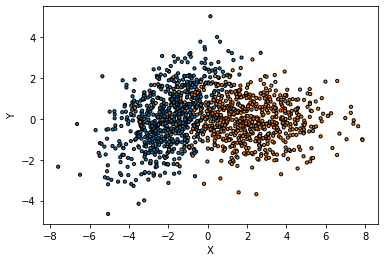

In [60]:
colors = {0: "#1f77b4", 1: "#ff7f0e"}
y_train_col = list(map(colors.get, y_train))
fig = plt.figure()
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    color=y_train_col,
    marker="o",
    s=10,
    edgecolor="k",
)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [61]:
clf = GaussianNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
y_pred_proba_max = np.max(y_pred_proba, axis=1)

calib = CalibratedClassifierCV(
    estimator=clf, method='sigmoid', cv='prefit'
)
calib.fit(X_c1, y_c1)

mapie_clf = MapieClassifier(
    estimator=calib, method='lac', cv='prefit', random_state=42
)
mapie_clf.fit(X_c2, y_c2)

alpha = [0.2, 0.1, 0.05]
y_pred_mapie, y_ps_mapie = mapie_clf.predict(
    X_test, alpha=0.05,
)

In [62]:
from src.utils import save_object

save_object(r"C:\Users\coach\myfiles\postdoc\Fire\test_save.pkl", mapie_clf)

In [64]:
model

MapieClassifier(cv='prefit',
                estimator=<catboost.core.CatBoostClassifier object at 0x00000269B94FC610>)

In [65]:
mapie_clf

MapieClassifier(cv='prefit',
                estimator=CalibratedClassifierCV(cv='prefit',
                                                 estimator=GaussianNB()),
                random_state=42)

In [63]:
mapie_clf = load_object(r"C:\Users\coach\myfiles\postdoc\Fire\test_save.pkl")
mapie_clf.predict(
    X_test, alpha=0.05,
)

(array([0, 0, 0, ..., 1, 1, 1]),
 array([[[ True],
         [False]],
 
        [[ True],
         [False]],
 
        [[ True],
         [False]],
 
        ...,
 
        [[False],
         [ True]],
 
        [[False],
         [ True]],
 
        [[False],
         [ True]]]))

In [11]:
np.squeeze(y_ps_mapie)

array([[ True, False],
       [ True, False],
       [ True, False],
       ...,
       [False,  True],
       [False,  True],
       [False,  True]])

In [24]:
import numpy as np

arr = np.array([[False, False], [True, True], [False, True], [True, False]])

def create_mask(arr):
    mask = ~np.all(arr == [True, False], axis=1)
    return mask

result_mask = create_mask(arr)

print(result_mask)


[ True  True  True False]
